# Digital Skills: Automated Image and Video Data Analysis with Python
## _University of Lucerne (Jan. 25, 2024)_
### Instructor:
### Dr. Natalia Umansky (University of Zurich)

___
___

# Session 1: Intro to Images as Data and Image Processing

<ins>**Objectives:**</ins>

  - **load images**: you'll learn how to load images into your python/notebook session.

  - **load videos**: you'll learn how to load vidoes into your python/notebook session.

  - **image representations**: you'll learn how images are represented from a mathematical/programmatic perspective. You'll be exposed to: (a) RGB 3-D representation, (b) grayscale 2-D representation, and (c) to embedding representations.

  - **from video to images**: you'll learn how to extract frames from videos, so how to split videos into images.

  - **image processing**: you'll learn how key image processing techniques, such as cropping, resizing, and rotating.

<ins>**Data/Datasets:**</ins>

  - **small celebrity dataset**: a dataset with some sample pictures of 5 celebrities (Mindy Kaling, Madonna, Jerry Seinfeld, Elton John, and Ben Affleck). For each of the celebrities we have about 14-20 train images, and 5 validation ones. These have not been cropped, so sometimes there is full body, not only the cropped face. I obtained the dataset from Kaggle: https://www.kaggle.com/dansbecker/5-celebrity-faces-dataset

  - **clips from ABC News: Biden G20 summit**: a news clip I pulled from ABC News' Youtube page: https://www.youtube.com/watch?v=68l6KPSavAo&ab_channel=ABCNews; so we can practice extracting frames from videos.

<ins>**Key module/s:**</ins>

  - **Pillow (PIL)**: python module with many image capabilities. Used by many for basic image-related tasks. You can find more information here: https://pillow.readthedocs.io/en/stable/

  - **Open CV (cv2)**: python module with for running many simple computer vision tasks.

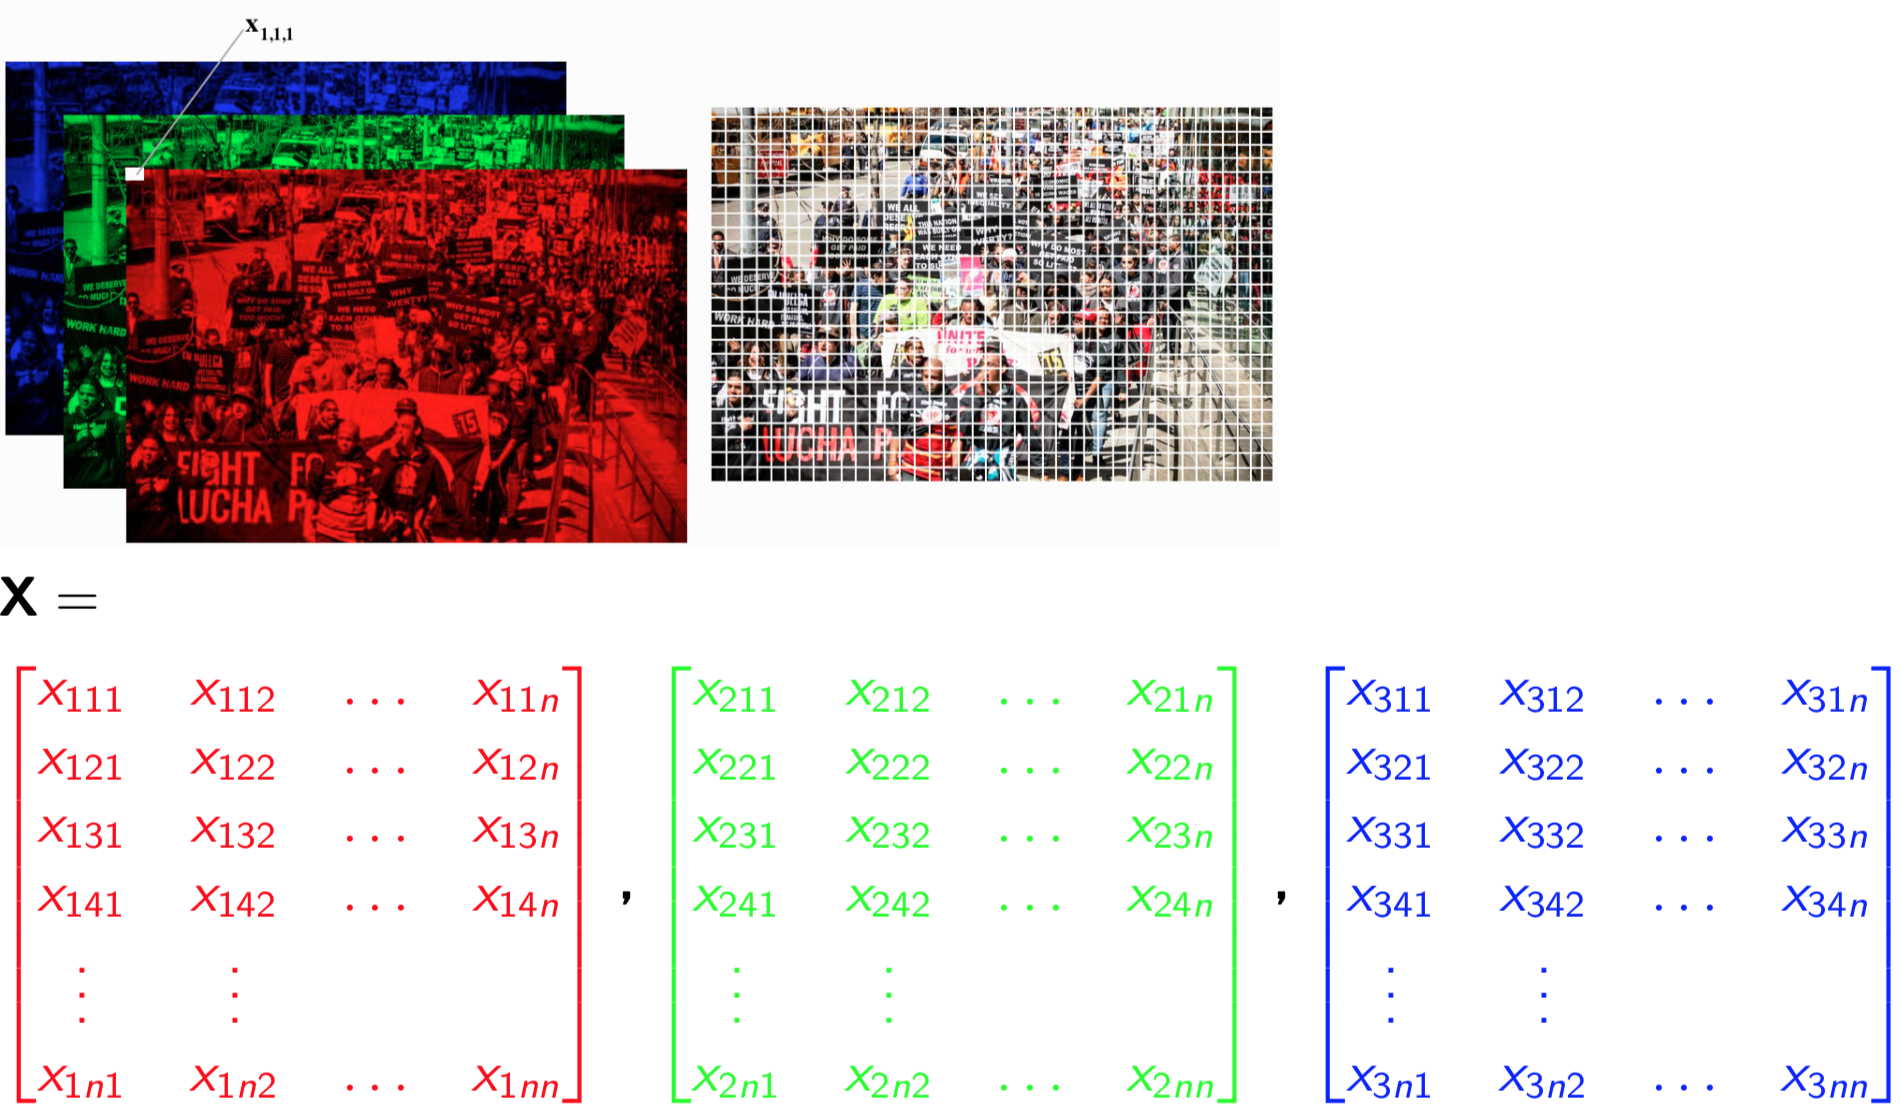

___
___

## 0. Install the packages/modules that we'll be using. Set up GPU.

These google-colab notebooks allow us to run code in virtual machines located elsewhere. Every time we start a session, the virtual machine is "empty", so non-native python modules need to be installed. Let's install the ones we'll need in this particular notebook. We'll do so using `pip` and the `!` marker that allows us to run `bash` code in the same notebook.

By default, it's not connected to GPU. But you can go to Runtime, Change runtime type, and select GPU.

In [1]:
# - before getting started, set up GPU.
import torch

# - get the GPU device name.
device_name = torch.cuda.get_device_name(0)

# - the device name should look like the following:
if torch.cuda.device_count() >= 1:
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: Tesla T4


This is the standard data processing function, that can (more or less) be applied as a standarized approach

In [2]:
# - a function we'll need to process images before using them as input of CNNs
def data_tranform(train = True, mean = [0.485, 0.456, 0.406],
                  sd = [0.229, 0.224, 0.225],
                  scale = 256, random_crop = 224):
    """
    Description: This function creates an object to transform train and
        test (or only testing) images.
    Parameters:
        `train`: type <bool> indicating if the object will need to be used
                    to transform training and testing images (=True) or
                    only testing.
        `mean`: type <list> of 3 floats indicating the mean value of the 3 RGB
                    image inputs.
        `sd`: type <list> of 3 floats indicating the standard deviation of
                    the 3 RGB mean inputs.
        `scale`: type <int> indicating the new size to give to the train and
                    test data (e.g. 256x256 pixel images).
        `random_crop`: type <int> indicating the size of the part of the image
                    really used for training-testing (e.g. 224x224)
    Output:
        An object to be used for preprocessing the train and test images
    Example:
        preprocess = data_transform()
    """
    if train:
        data_transforms = {
            'train': transforms.Compose([
                transforms.Resize(scale),
                transforms.RandomSizedCrop(random_crop),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, sd)
            ]),
            'test': transforms.Compose([
                transforms.Resize(scale),
                transforms.CenterCrop(random_crop),
                transforms.ToTensor(),
                transforms.Normalize(mean, sd)
            ]),
        }
    else:
        data_transforms = transforms.Compose([
            transforms.Resize(scale),
            transforms.CenterCrop(random_crop),
            transforms.ToTensor(),
            transforms.Normalize(mean, sd)
        ])
    return(data_transforms)

## 1. Load the modules that we'll be using

In [3]:
import os
from PIL import Image, ImageOps # also for image manipulation
from google.colab import drive # module to mount the google drive
import numpy as np
import cv2 # module for simple computer vision tasks

In [4]:
# - pytorch for deep learning modeling
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

## 2. Mount the Google Drive for the workshop to this virtual machine

In [5]:
# - it will generate a url. Click on it, specify the google account you want to
#   use, and
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## 3. Declare the data path

In [6]:
data_path = '/content/gdrive/MyDrive/lucerne-digital-skills/data/'

## 4. Loading images

In [7]:
# - use the functionalities of the PIL package to load an example image. Let's
#   use one of the images of the celebrity dataset.
celeb_path = '{}small-celeb-data/train/'.format(data_path)
img_path = '{}elton_john/httpssmediacacheakpinimgcomxfcfcbaeaeddabbjpg.jpg'.format(
    celeb_path
)
# - /!\ here is where the loading takes place
img = Image.open(img_path)

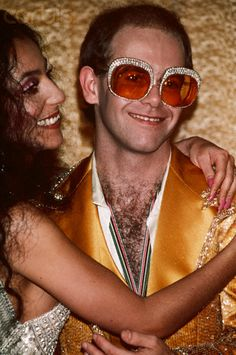

In [8]:
img

## 5. Image representations

### 5.1 RGB 3-D representation

In [9]:
# - transform the PIL Image object to a numpy array to explore the raw 3-D
#   RGB representation.
img_array = np.array(img)

In [10]:
# - a 3D array containin information about the intensity of Red, Green, and Blue
#   for each pixel in the image.
#   These color intensities range from 0 (meaning there is no e.g. Red), to 255.
img_array.shape # width, height, depth

(355, 236, 3)

In [11]:
img_array

array([[[111,  78,  37],
        [115,  82,  41],
        [114,  82,  41],
        ...,
        [154, 128,  93],
        [151, 125,  90],
        [142, 116,  81]],

       [[104,  71,  30],
        [111,  78,  37],
        [112,  80,  39],
        ...,
        [139, 113,  78],
        [136, 110,  75],
        [131, 105,  70]],

       [[101,  68,  25],
        [107,  74,  31],
        [109,  76,  33],
        ...,
        [100,  74,  39],
        [ 95,  69,  34],
        [ 96,  70,  35]],

       ...,

       [[ 68,  70,  57],
        [106, 108,  95],
        [145, 147, 133],
        ...,
        [126,  55,  11],
        [154,  77,  25],
        [172,  91,  35]],

       [[ 34,  37,  26],
        [ 73,  76,  65],
        [ 97,  99,  86],
        ...,
        [121,  50,   4],
        [152,  71,  16],
        [170,  84,  23]],

       [[ 74,  77,  66],
        [111, 114, 103],
        [116, 118, 105],
        ...,
        [111,  40,   0],
        [140,  59,   4],
        [157,  73,  13]]

In [12]:
img_array.min()

0

In [13]:
img_array.max()

255

In [14]:
# - let's get rid of the first color channel (Red)
img_array[:,:,0] = 0

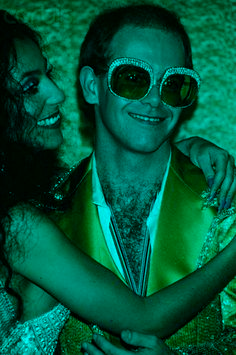

In [15]:
Image.fromarray(img_array)

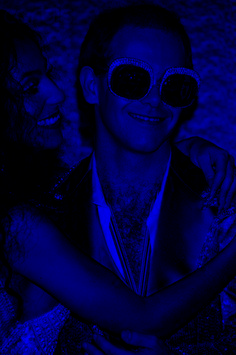

In [16]:
# - let's do the same with the second color channel (Green)
img_array[:,:,1] = 0
Image.fromarray(img_array)

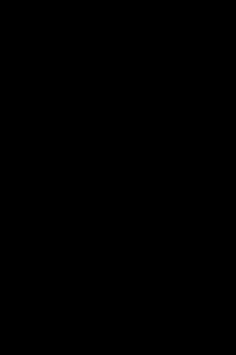

In [17]:
# - and finally get rid of the third color channel (Blue)
img_array[:,:,2] = 0
Image.fromarray(img_array)

### 5.2 Grayscale 2-D representation

The advantage of working with grayscale representations is that it reduces the amount of computer power needed. But in general it's better to work with colors

In [18]:
# - use one of the functions in the PIL module to transform the sample image to
#   grayscale
img_gray = ImageOps.grayscale(img)

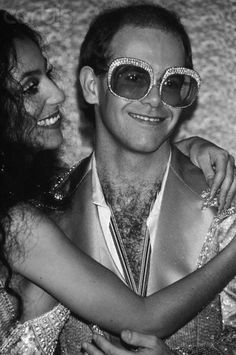

In [19]:
img_gray

In [20]:
# - transform to a numpy array to check how the grayscale representation looks
imggray_array = np.array(img_gray)

In [21]:
# - only 2 dimensions (height, width) -- no depth (so no 3-color channel)
imggray_array.shape

(355, 236)

In [22]:
# - the numbers indicate the intensity of black/gray in each pixel. Same range,
#   from 0 (completely black) to 255 (completely white).
imggray_array

array([[ 83,  87,  87, ..., 132, 129, 120],
       [ 76,  83,  85, ..., 117, 114, 109],
       [ 73,  79,  81, ...,  78,  73,  74],
       ...,
       [ 68, 106, 145, ...,  71,  94, 109],
       [ 35,  74,  97, ...,  66,  89, 103],
       [ 75, 112, 116, ...,  57,  77,  91]], dtype=uint8)

In [23]:
imggray_array.min()

2

In [24]:
imggray_array.max()

254

You can make one section of the image completely black (or white) by:

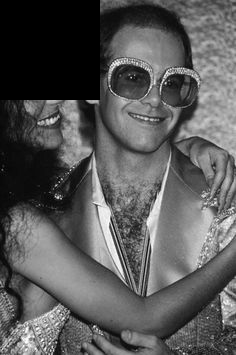

In [25]:
imggray_array[0:100,0:100] = 0
Image.fromarray(imggray_array)

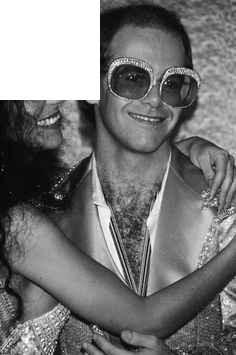

In [26]:
imggray_array[0:100,0:100] = 255
Image.fromarray(imggray_array)

## 5.3 Image embedding
Sometimes we want to leverage the information learned by rich pre-trained deep models and express images as embeddings/vectors. We can then use such embeddings e.g. to compute image similarity.

Resnet is one of the most used pre-trained image embeddings

In [27]:
# - load pre-trained image model: Resnet18.
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 108MB/s]


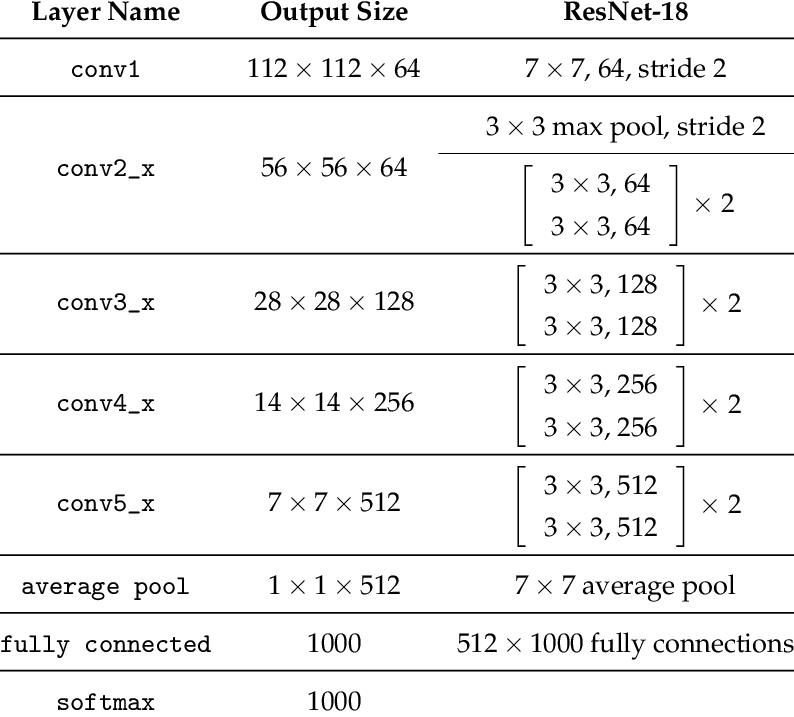

In [28]:
# - we will get rid of the last fully connected layer, which means that we'll
#   generate embeddings of size 512. And we'll make sure we don't run
#   backpropagation.
for param in model.parameters(): #
    param.requires_grad = False
model.eval()

encoder = nn.Sequential(*list(model.children())[:-1]) # drop last layer
resnet_preprocess = data_tranform(train = False) # preprocessing info
if torch.cuda.is_available(): # making sure we're using GPUs
    model = model.cuda()

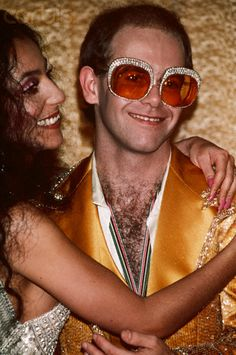

In [29]:
img

In [30]:
# - use the encoder (pre-trained CNN -- Resnet18), to represent the sample image
#   as a dense vector
# ... transform the image (centering the color values)
img_transformed = Variable(resnet_preprocess(img).unsqueeze(0))
img_embedding = encoder(img_transformed.cuda()).cpu().detach().numpy().flatten()

In [31]:
img_embedding

array([7.26116728e-03, 3.99091095e-01, 9.34610784e-01, 8.93190384e-01,
       6.43264279e-02, 5.07065237e-01, 1.45919514e+00, 4.19779658e-01,
       5.70402220e-02, 6.52929664e-01, 4.41477746e-01, 3.09692807e-02,
       3.78920346e-01, 1.03381562e+00, 1.47369593e-01, 1.87598482e-01,
       1.19010711e+00, 1.58331203e+00, 2.38820836e-01, 1.47106218e+00,
       4.23926950e-01, 6.50966406e-01, 1.75591990e-01, 7.24376261e-01,
       1.52686512e+00, 8.57232273e-01, 1.96643591e+00, 1.49553704e+00,
       1.41258493e-01, 7.52044395e-02, 1.08328795e+00, 5.06776392e-01,
       7.69568920e-01, 2.99374270e+00, 1.32562125e+00, 4.36387286e-02,
       5.64955235e-01, 2.35879615e-01, 2.93433487e-01, 5.30508101e-01,
       9.17641163e-01, 1.42532420e+00, 3.84310317e+00, 6.62209630e-01,
       3.79334736e+00, 6.46839499e-01, 9.87194598e-01, 1.35602367e+00,
       6.08735561e-01, 1.82718575e+00, 1.05383016e-01, 4.80766296e-02,
       1.14858272e-02, 4.54576522e-01, 7.75712058e-02, 9.53256309e-01,
      

In [32]:
len(img_embedding)

512

## 6. Basic image processing

### 6.1 Resizing / Squishing

Often we want to work with images of the same exact size, usually a square format (e.g. 224 x 224). For example, when feeding images to a pre-trained CNN model. An option when the original image files are of different size, is to resize them so they are all of the same size. However, as you will see, we may end up deforming images too much, complicating many analytical tasks down the line.

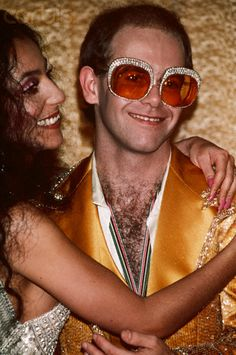

In [33]:
# - let's keep working with this same image example
img

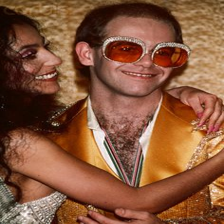

In [34]:
# - PIL Image objects/classes already come with a resize function. Let's try it!
img.resize((224,224))

### 6.2 Cropping

An alternative to avoid deforming the image is to crop part of it. The problem there however is that we may end up missing parts of the images that are relevant for our analysis.

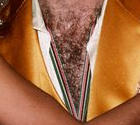

In [35]:
# - the PIL Image class comes with a function to do the cropping. You need to
#   provide a 4-coord box to this function indicating the (left, top, right,
#   bottom) points to use during cropping
img.crop((60, 175, 200, 300))

### 6.3 Cropping and Resizing

A better alternative is to combine cropping and resizing. First, we make sure we have a square image (the width and the height is the same) by excluding the least parts/amounts of the image possible. Then, we transform the square image to the desired size.

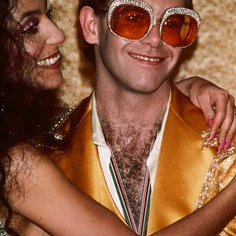

In [36]:
height = img.height
width = img.width
hw_dif = abs(height - width)
hw_halfdif = hw_dif / 2
crop_leftright = width > height
if crop_leftright:
    y0 = 0
    y1 = height
    x0 = 0 + hw_halfdif
    x1 = width - hw_halfdif
else:
    y0 = 0 + hw_halfdif
    y1 = height - hw_halfdif
    x0 = 0
    x1 = width
img.crop((x0, y0, x1, y1))

### 6.4 Rotation

For data-augmentation and generalizability purposes, we want to rotate images at random when training a deep learning image model. The tasks explain in this section 7, including rotation, are handled automatically by any deep learning library (e.g. `pytorch`). Nevertheless, it's also good to know how to do these things "manually", to know what's going on in the back (which e.g. helps debugging) but also in case you need to do it by yourself in the future.

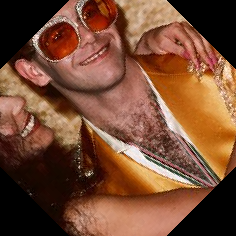

In [37]:
# - the PIL Image class also comes with a rotate function. You only need to
#   specify the angles to be rotated.
img.crop((x0, y0, x1, y1)).rotate(45)

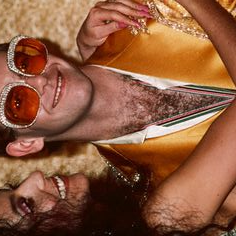

In [38]:
img.crop((x0, y0, x1, y1)).rotate(90)

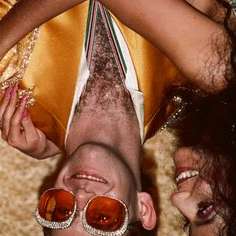

In [39]:
img.crop((x0, y0, x1, y1)).rotate(180)

## 7. Loading videos & extracting frames/images from videos

In [72]:
data_path

'/content/gdrive/MyDrive/lucerne-digital-skills/data/'

In [73]:
# - path to the video file
video_path = '{}abc-news-biden-g20.mp4'.format(data_path)

In [74]:
# - create an output subdirectory where we can place the frames we'll extract
#   from the video

output_path = '/content/gdrive/MyDrive/lucerne-digital-skills/output'
output_path02 = '{}/video_frames/'.format(output_path)
if not os.path.isdir(output_path02):
  os.mkdir(output_path02)

In [75]:
# - use Open CV to load (open connection with) the video
vidcap = cv2.VideoCapture(video_path)
success, image = vidcap.read()

In [76]:
# - make sure it worked
success

True

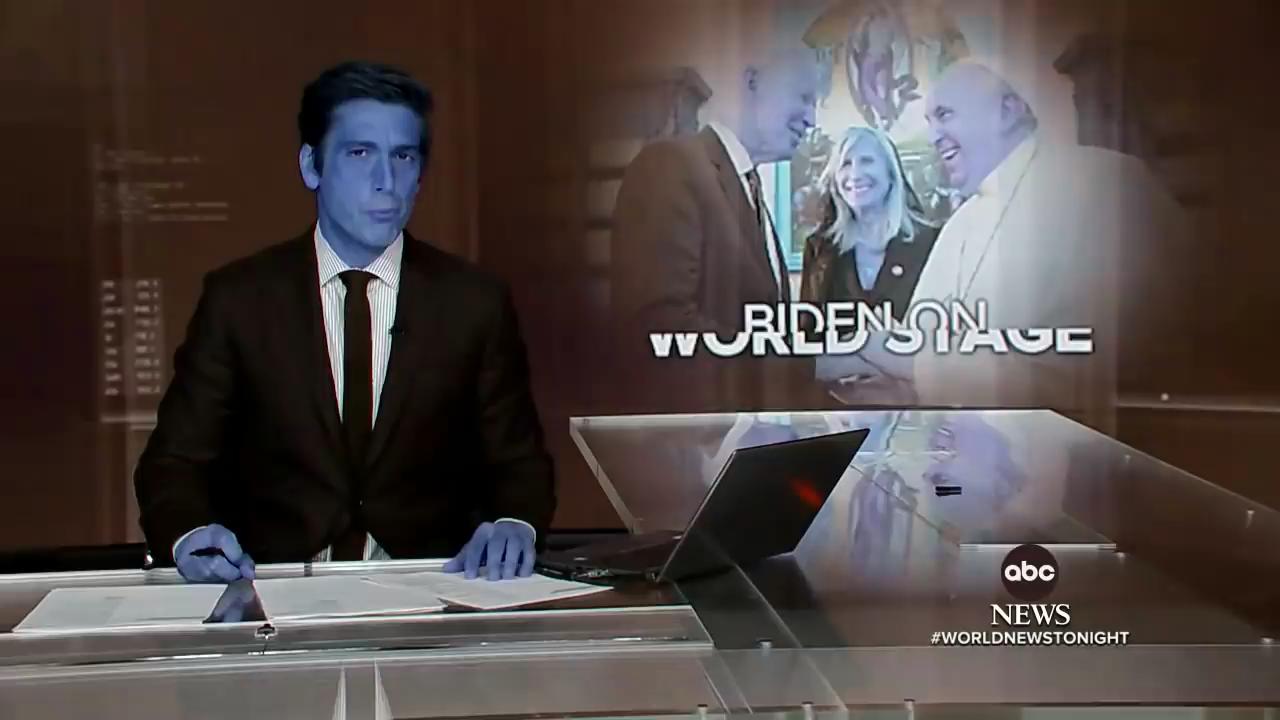

In [78]:
# - take a look at the thumbnail
Image.fromarray(image)

In [69]:
# - check the number of frames per second in this video
fps = round(vidcap.get(cv2.CAP_PROP_FPS))

# - set up how many frames per second you want
fps_needed = 2

# - calculate how many frames to skip before saving next frame
fps_max = round(fps / fps_needed)

In [79]:
# - start playing the video (in the back) and extracting and saving frames
counter = fps_max
macro_counter = 0
saved_frames = 0
while vidcap.isOpened():
  ret, frame = vidcap.read()
  macro_counter += 1
  if ret:
    if counter == fps_max:
      #print('new frame saved')
      saved_frames += 1
      cv2.imwrite('{}frame{:d}.jpg'.format(output_path02, saved_frames), frame)
      vidcap.set(cv2.CAP_PROP_POS_FRAMES, macro_counter)
      counter = 0
    if macro_counter == (30 * fps):
      # - /!\ let's stop after 30 seconds to keep things simple
      break
  else:
    vidcap.release()
    break
  counter += 1


In [ ]:
# - take a look at the output folder, the image/frames should be there! :)